# Community Citation Analysis 

Making use of a community citation analysis to identify groups/communities in the behavious of works citing each other.

In [1]:
#import necessary packages
import networkx as nx
import numpy as np
from community import community_louvain #pip install python-louvain package
import leidenalg as la
import igraph as ig
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

## Read the data

Read the data generated by get_data_openalex.ipynb notebook.

In [2]:
fake_data = 1
toprint = 1 #Flag to print information (turn off if using a large dataset!)

In [3]:
# Load the data
data_file = '../data/openAlex/test/pub2ref.csv'
if fake_data == 1: data_file = '../data/fake/citation_data_fake.csv'
citation_data = pd.read_csv(data_file)

#citation_data = citation_data[0:1000]

In [4]:
print("Information of the data being used:")
print()
citation_data.info()
print()
print(citation_data.head(20))

Information of the data being used:

<class 'pandas.DataFrame'>
RangeIndex: 138 entries, 0 to 137
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   paper_name  138 non-null    str  
 1   source      138 non-null    str  
 2   target      138 non-null    str  
dtypes: str(3)
memory usage: 9.5 KB

   paper_name               source               target
0     Paper 1  WOS:000279731700007  WOS:000279731700009
1     Paper 1  WOS:000279731700007  WOS:000396401600013
2     Paper 1  WOS:000279731700007  WOS:000365063100009
3     Paper 1  WOS:000279731700007  WOS:001265701800001
4     Paper 1  WOS:000279731700007  WOS:000587608600026
5     Paper 1  WOS:000279731700007  WOS:000492417900009
6     Paper 1  WOS:000279731700007  WOS:000380450900007
7     Paper 1  WOS:000279731700007  WOS:001336892600004
8     Paper 2  WOS:000365063100009  WOS:000279731700007
9     Paper 2  WOS:000365063100009  WOS:001336892600004
10    Paper 2  WOS:000

## Perform the community analysis

Makes use [networkx](https://networkx.org/documentation/stable/) package, [igraph](https://python.igraph.org/en/stable/) package.

### Set up the graphs 

A `Graph` is a collection of nodes (in this case, works) and edges (in this case lines representing citations between works). Should identify pairs of nodes (i.e., in this case, two works that have a citation link between them). We are using OpenAlex IDs to define nodes in this example. Our tables are effectively a long list of edges because we have created a list of every pair of citations (sources and targets or publication_ids and reference_ids). So we use the citation_data to add all of these edges to the Graph.

With `iGraph` object, we can do fast manipulation and analysis. [`ig.Graph.TupleList`](https://python.igraph.org/en/main/api/igraph.Graph.html#TupleList) constructs a graph for a list of tuples (which is what we had in out `Graph`. We have set directed=True, which I think keeps track of the direction of the edge (i.e., which is the citing and which is the cited work in this case).

In [5]:
# Create a directed graph
G_networkX = nx.DiGraph()#create an empty graph

if fake_data == 1:
    G_networkX.add_edges_from(citation_data[['source', 'target']].values) 
else: G_networkX.add_edges_from(citation_data[['publication_id', 'reference_id']].values) #create the edges

# Convert the NetworkX graph to an iGraph object
g_iGraph = ig.Graph.TupleList(G_networkX.edges(), directed=True)

### Perform the partition

Uses the [leidenalg](https://leidenalg.readthedocs.io/en/stable/intro.html) package. This is seems to be behaving well on the fake data I generated, recovering the citation communities I artificially created.

In [6]:
# Perform Leiden community detection (note the number of iterations is how many times the algorithm is used, if make it negative then runs until not improvement)
partition = la.find_partition(g_iGraph, la.ModularityVertexPartition, n_iterations=2)

# Get the community assignments
community_ids = partition.membership

### Tidy and print some information about the communities identified

In [7]:
if toprint == 1: print(partition)
print()

#Print overview of communities identied
print("")
print("----Partition Overview----")
print("Number of nodes (elements):",partition.n)
print("Number of communities:",len(partition))
print("")

Clustering with 26 elements and 5 clusters
[0] WOS:000279731700007, WOS:000279731700009, WOS:000365063100009,
    WOS:001265701800001, WOS:000587608600026, WOS:000492417900009,
    WOS:000380450900007
[1] WOS:000278584300025, WOS:001337593100008, WOS:000484590300001,
    WOS:001352180500100, WOS:000519098200104, WOS:001337581700004
[2] WOS:000396401600013, WOS:001336892600004, WOS:001087472600001,
    WOS:000243205900006, WOS:000345168400011
[3] WOS:000274369800014, WOS:001381043200001, WOS:001259864900041,
    WOS:000573482500002
[4] WOS:000380410400105, WOS:000310847300019, WOS:000674894000002,
    WOS:001062040400001


----Partition Overview----
Number of nodes (elements): 26
Number of communities: 5



In [8]:
# Create a dictionary mapping nodes to community IDs
node_community = {node: community_id for node, community_id in zip(G_networkX.nodes(), community_ids)}

### Calculate some community metrics

Will go to each community and get the size (i.e., the number of works in the community) and density of each of these.

The [density](https://networkx.org/documentation/stable/reference/generated/networkx.classes.function.density.html) is 0 for a graph without edges and 1 for a complete graph. The density of multigraphs can be higher than 1.

In [9]:
#Create a dictionary of the information about the community metrics
community_metrics = {}
for community_id in set(community_ids):
    #get number of works (nodes) in each community
    community_nodes = [node for node, cid in node_community.items() if cid == community_id]
    #get density in each node [what is this?!?!]
    community_graph = G_networkX.subgraph(community_nodes)
    community_metrics[community_id] = {
        'size': len(community_nodes),
        'density': nx.density(community_graph)
    }

# Print community metrics (number of papers in each community and the density)
for community_id, metrics in community_metrics.items():
    print(f"Community {community_id}: size={metrics['size']}, density={metrics['density']}")
print("-------------")
print("")
if toprint == 1: print(community_metrics)

Community 0: size=7, density=0.9761904761904762
Community 1: size=6, density=0.13333333333333333
Community 2: size=5, density=0.3
Community 3: size=4, density=0.25
Community 4: size=4, density=0.5
-------------

{0: {'size': 7, 'density': 0.9761904761904762}, 1: {'size': 6, 'density': 0.13333333333333333}, 2: {'size': 5, 'density': 0.3}, 3: {'size': 4, 'density': 0.25}, 4: {'size': 4, 'density': 0.5}}


<h1>Make figure</h1>

In [10]:
#testing that everything is consistent
if toprint ==1:
    print(list(G_networkX.nodes()))
    print()
    print(list(node_community.values()))
    print()
    print(community_ids)
    print()
    for keys,values in node_community.items():
        print(keys,values)

['WOS:000279731700007', 'WOS:000279731700009', 'WOS:000396401600013', 'WOS:000365063100009', 'WOS:001265701800001', 'WOS:000587608600026', 'WOS:000492417900009', 'WOS:000380450900007', 'WOS:001336892600004', 'WOS:000274369800014', 'WOS:001381043200001', 'WOS:000380410400105', 'WOS:001087472600001', 'WOS:000310847300019', 'WOS:001259864900041', 'WOS:000278584300025', 'WOS:001337593100008', 'WOS:000484590300001', 'WOS:001352180500100', 'WOS:000519098200104', 'WOS:001337581700004', 'WOS:000243205900006', 'WOS:000345168400011', 'WOS:000674894000002', 'WOS:001062040400001', 'WOS:000573482500002']

[0, 0, 2, 0, 0, 0, 0, 0, 2, 4, 2, 2, 2, 3, 3, 4, 3, 3, 4, 4, 1, 1, 1, 1, 1, 1]

[0, 0, 2, 0, 0, 0, 0, 0, 2, 4, 2, 2, 2, 3, 3, 4, 3, 3, 4, 4, 1, 1, 1, 1, 1, 1]

WOS:000279731700007 0
WOS:000279731700009 0
WOS:000396401600013 2
WOS:000365063100009 0
WOS:001265701800001 0
WOS:000587608600026 0
WOS:000492417900009 0
WOS:000380450900007 0
WOS:001336892600004 2
WOS:000274369800014 4
WOS:001381043200001 


['WOS:000279731700007', 'WOS:000279731700009', 'WOS:000396401600013', 'WOS:000365063100009', 'WOS:001265701800001', 'WOS:000587608600026', 'WOS:000492417900009', 'WOS:000380450900007', 'WOS:001336892600004', 'WOS:000274369800014', 'WOS:001381043200001', 'WOS:000380410400105', 'WOS:001087472600001', 'WOS:000310847300019', 'WOS:001259864900041', 'WOS:000278584300025', 'WOS:001337593100008', 'WOS:000484590300001', 'WOS:001352180500100', 'WOS:000519098200104', 'WOS:001337581700004', 'WOS:000243205900006', 'WOS:000345168400011', 'WOS:000674894000002', 'WOS:001062040400001', 'WOS:000573482500002']
[0, 0, 2, 0, 0, 0, 0, 0, 2, 4, 2, 2, 2, 3, 3, 4, 3, 3, 4, 4, 1, 1, 1, 1, 1, 1]


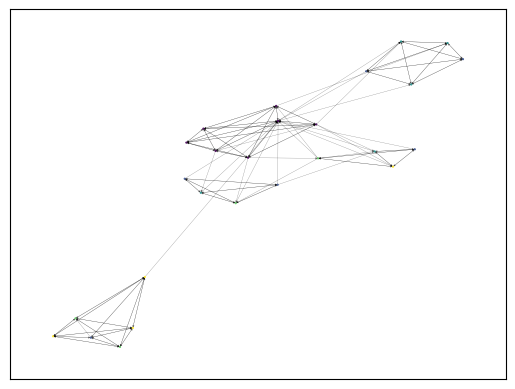

In [11]:
# Sort out colors to match the community IDs ***not working**
colors = community_ids
if toprint == 1:
    print("")
    print(G_networkX.nodes())
    print(colors)
    

#Plotting options
options = {
    'node_size': 10,
    'width': 0.1,
    'arrowsize': 5,
    'with_labels': False
}

node_size = 0.3

pos = nx.spring_layout(G_networkX)
cmap = plt.get_cmap('viridis', max(node_community.values()) + 1)
nx.draw_networkx_nodes(G_networkX, pos, node_community.keys(), node_size=0.3,
                       cmap=cmap,node_color=node_community.values())
nx.draw_networkx_edges(G_networkX, pos, alpha=0.5, width=0.2, arrowsize=3,node_size=node_size+0.2)
#also try spectral_layout and viridis


plt.savefig("../output/figures/output.png",dpi=800)
plt.show()

## Trying with Louvain
Following: [https://github.com/taynaud/python-louvain](https://github.com/taynaud/python-louvain)

This might still be possible using [leidenalg package](https://leidenalg.readthedocs.io/en/stable/advanced.html) and can just edit above code

In [ ]:
# compute the best partition using the louvian
#partition = community_louvain.best_partition(G_networkX)
#for key in partition:
#    print (key,partition[key])

In [ ]:
# draw the graph
pos = nx.spring_layout(G_networkX)
# color the nodes according to their partition
cmap = plt.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G_networkX, pos, partition.keys(), node_size=30,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G_networkX, pos, alpha=0.5)
plt.show()

## Get community metrics and print results data